# Content <a id = "cont"></a>
- [Dataset](#1)
- [EDA](#2)
- [CLTV](#4)
    - [Data Prep](#4a)
    - [BG-NBD](#4c)
    - [Gamma Gamma](#4d)
    - [Segmentation](#4e)
    - [Model Validation](#4f)

In [1]:
# !pip install pandas
# !pip install plotly
# !pip install scikit-learn
# !pip install lifetimes
# !pip install duckdb

In [2]:
import numpy as np 
import pandas as pd 
import datetime as dt
import plotly.express as px
import duckdb

# Dataset <a id = "1"> </a>

- [https://archive.ics.uci.edu/ml/datasets/Online+Retail+II](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)  OR
- download from [Kaggle Dataset](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci/data?select=online_retail_II.csv) too.

In [3]:
# Read Dataset
data = pd.read_csv("online_retail_II.csv")
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# EDA <a id = "2"> </a>

In [4]:
##-- standardize column names
# data.columns = data.columns.str.replace(' ', '_').str.lower()
data.columns = data.columns.str.replace(' ', '_')

In [5]:
# check shape
data.shape

(1067371, 8)

In [6]:
# check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer_ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [7]:
## convert date to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# to date only
data['InvoiceDate'] = data['InvoiceDate'].dt.date

In [8]:
# column null value count
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer_ID    243007
Country             0
dtype: int64

In [9]:
# column unique value check
data.nunique()

Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate      604
Price           2807
Customer_ID     5942
Country           43
dtype: int64

In [10]:
# flag return orders
data['isReturn'] = data["Invoice"].str.contains("C", na=False)

In [11]:
# flag adjusted orders
data['isAdjusted'] = data["Invoice"].str.contains("A", na=False)

In [12]:
# get counts for each value
data['isReturn'].value_counts()

isReturn
False    1047877
True       19494
Name: count, dtype: int64

In [13]:
data['isAdjusted'].value_counts() 

isAdjusted
False    1067365
True           6
Name: count, dtype: int64

In [14]:
# remove returned and adjusted orders
data = data[(data['isReturn'] == False) & (data['isAdjusted'] == False)]

In [15]:
# calculate stock total
data['TotalPrice'] = data['Quantity'] * data['Price']

In [16]:
# remove Quantity <= 0 orders or price <= 0 orders
data = data[data['Quantity'] >= 0]
data = data[data["Price"] >= 0]

In [17]:
# Dataset ordered from lowest price to highest price
data.sort_values(by = "TotalPrice", ascending  = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,isReturn,isAdjusted,TotalPrice
1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,16446.0,United Kingdom,False,False,168469.60
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,False,False,77183.60
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10,649.50,15098.0,United Kingdom,False,False,38970.00
241827,512771,M,Manual,1,2010-06-17,25111.09,NaN,United Kingdom,False,False,25111.09
432176,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04,1.69,15838.0,United Kingdom,False,False,15818.40


In [18]:
print(data["InvoiceDate"].min(), data["InvoiceDate"].max())

2009-12-01 2011-12-09


In [19]:
data.shape

(1044414, 11)

# CLTV <a id = "4"></a>
<center>
<div class="alert alert-block alert-info">
<b>What is the CLTV(Customer lifetime value)?</b> </div></center>

<div style="width:100%;text-align: center;"> <img align=middle src="https://www.namogoo.com/wp-content/uploads/2021/08/featured-1.jpg" alt="Heat beating" style="height:300px;margin-top:1rem;margin-bottom:1rem;"> </div>
Customer Lifetime Value (CLTV) is a prediction of the net profit attributed to the entire future relationship with a customer. It estimates the total value a business will derive from a customer relationship, taking into account the revenue, costs, and customer behavior patterns over a defined period of time. CLTV helps businesses understand the value of customer acquisition and retention, and guide decisions about investment in customer relationship management initiatives.



**BetaGeoFitter** and **GammaGammaFitter** models are used here. 
 - **BetaGeoFilter** model is used to predict how often a customer makes a purchase. 
 - **GammaGammaFilter** model is used to predict how much profit a customer will bring.


Create features as below, check [BetaGeoFitter source code link](https://github.com/CamDavidsonPilon/lifetimes/blob/e3e551ac5e0ce5cd91a4c6c74cd66ee7b4c77e5e/lifetimes/fitters/beta_geo_fitter.py) for details.

**Age (T):** the time between the first transaction and current date<br>
**Recency:** the time between the first and last transaction<br>
**Frequency:** the amount of transactions made per consumer per period, for example, if the frequency is daily, then 1 is applied for the day’s transactions, regardless of how many have been made on that day. That said, 10 transactions made by a consumer in two days will equal two in the frequency field<br>
**Monetary:** the average value of purchases, total/frequence<br>

## Data Prep <a id="4a"></a>

In [20]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,isReturn,isAdjusted,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,False,False,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,False,False,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,False,False,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,False,False,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,False,False,30.0


In [21]:
# It is the last date in the dataset. I will need this to calculate the recency values. I'm going to use this to specify the today_date value.
data["InvoiceDate"].max()

datetime.date(2011, 12, 9)

In [22]:
# choose last_date in the dataset + 2 as current date. 
today_date = dt.date(2011, 12, 11)

In [23]:
data = data[['Customer_ID', 'InvoiceDate', 'TotalPrice']]

### use function <a id="4a1"></a>

In [24]:
# Create the df_cltv dataframe.
df_cltv = data.groupby("Customer_ID").agg({"InvoiceDate" : [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # recency
                                                            lambda InvoiceDate: (today_date - InvoiceDate.min()).days, # T
                                                            lambda InvoiceDate: InvoiceDate.nunique()], # frequence
                                           "TotalPrice": lambda TotalPrice: TotalPrice.sum()}) # monatery

In [25]:
# I specfy the column name of df_cltv
df_cltv.columns = ["recency", "T", "frequnecy", "monetary"]

In [26]:
# filter out the first order
df_cltv = df_cltv[df_cltv["frequnecy"] > 1]

In [27]:
# Average earnings per purchase
df_cltv["monetary"] = df_cltv["monetary"] / df_cltv["frequnecy"]

In [28]:
# # turn the recency and T values to the weekly format 
# df_cltv["recency"] = df_cltv["recency"] / 7
# df_cltv["T"] = df_cltv["T"] / 7

In [29]:
df_cltv.head()

,recency,T,frequnecy,monetary
Customer_ID,,,,
12346.0,400,727,8,9694.557500
12347.0,402,406,8,704.165000
12348.0,363,440,5,403.880000
12349.0,571,591,4,1107.172500
12352.0,356,394,9,316.648889


### use sql <a id="4a2"></a>  

In [30]:
sql_query = """
with t AS 
(
select 
Customer_ID, 
min(InvoiceDate) as min_date, 
max(InvoiceDate) as max_date,
count(distinct InvoiceDate) as frequence,
sum(TotalPrice) as monetary
from data
group by 1
)
select 
Customer_ID,
frequence,
date_diff('day', min_date, max_date) as recency,
date_diff('day', min_date, DATE '2011-12-11') as T,
monetary/frequence as monetary_value
from t
order by Customer_ID
"""

df_cltv_sql = duckdb.query(sql_query).to_df()
df_cltv_sql.head()

,Customer_ID,frequence,recency,T,monetary_value
0,12346.0,8,400,727,9694.5575
1,12347.0,8,402,406,704.1650
2,12348.0,5,363,440,403.8800
3,12349.0,4,571,591,1107.1725
4,12350.0,1,0,312,334.4000


### use summary_data_from_transaction_data <a id="4a3"></a>  
[reference link](https://lifetimes.readthedocs.io/en/latest/lifetimes.html#module-lifetimes.utils)

In [31]:
import lifetimes
print(lifetimes.__version__)
_data = data[['Customer_ID', 'InvoiceDate', 'TotalPrice']]
rfm = lifetimes.utils.summary_data_from_transaction_data (_data, 
     customer_id_col = 'Customer_ID', 
     datetime_col = 'InvoiceDate', 
     monetary_value_col = 'TotalPrice',
     observation_period_end = today_date, 
     freq='D',
     include_first_transaction = True  # normally, not 
    ) 
rfm.head()

0.11.3


,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,8.0,400.0,727.0,9694.5575
12347.0,8.0,402.0,406.0,704.1650
12348.0,5.0,363.0,440.0,403.8800
12349.0,4.0,571.0,591.0,1107.1725
12350.0,1.0,0.0,312.0,334.4000


**As shown above, all three methods have the same results. Just for demonstration purpose**

In the summary_data_from_transaction_data method, the first transaction by default is not included while calculating the frequency and monetary value. To include it, just set the parameter include_first_transaction to True. To use the data with some fitters from the lifetimes package, **this parameter include_first_transaction must be set to False**. So we re-generate input_df


In [32]:
input_df = lifetimes.utils.summary_data_from_transaction_data (_data, 
     customer_id_col = 'Customer_ID', 
     datetime_col = 'InvoiceDate', 
     monetary_value_col = 'TotalPrice',
     observation_period_end = today_date, 
     freq='D',
     include_first_transaction = False  
    ) 
input_df.head()

,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,7.0,400.0,727.0,11066.637143
12347.0,7.0,402.0,406.0,717.398571
12348.0,4.0,363.0,440.0,449.310000
12349.0,3.0,571.0,591.0,1120.056667
12350.0,0.0,0.0,312.0,0.000000


## BG/NBD <a id= "4b"></a>

In [33]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [34]:
# Model
bgf = BetaGeoFitter(penalizer_coef = 0.001)

# fit with frequency, recency, and T values.
bgf.fit(input_df["frequency"],
       input_df["recency"],
       input_df["T"])

<lifetimes.BetaGeoFitter: fitted with 5881 subjects, a: 0.08, alpha: 63.38, b: 1.24, r: 0.66>

At the code block below, I calculate how often shop customers in one month with the BetaGeoFitter model.

### next 30 days frequence prediction <a id= "4b1"></a>

In [35]:
t=30

In [36]:
# Calculating next 30 days frequency
# 
bgf.predict(t, # one month
           input_df["frequency"],
           input_df["recency"],
           input_df["T"])

Customer_ID
12346.0    0.179173
12347.0    0.483301
12348.0    0.267063
12349.0    0.163433
12350.0    0.052890
             ...   
18283.0    0.769227
18284.0    0.040033
18285.0    0.027418
18286.0    0.049163
18287.0    0.260918
Length: 5881, dtype: float64

In [37]:
# OR use conditional_expected_number_of_purchases_up_to_time, same result
bgf.conditional_expected_number_of_purchases_up_to_time(t,input_df["frequency"],
           input_df["recency"],
           input_df["T"])

Customer_ID
12346.0    0.179173
12347.0    0.483301
12348.0    0.267063
12349.0    0.163433
12350.0    0.052890
             ...   
18283.0    0.769227
18284.0    0.040033
18285.0    0.027418
18286.0    0.049163
18287.0    0.260918
Length: 5881, dtype: float64

In [38]:
input_df["expected_purc_30_days"] = bgf.predict(t, 
                                               input_df["frequency"],
                                               input_df["recency"],
                                               input_df["T"])

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

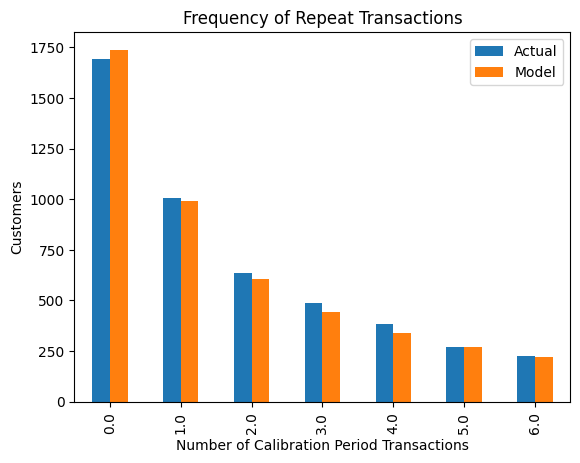

In [39]:
plot_period_transactions(bgf)

### next 90 days frequence prediction <a id= "4b2"></a>

In [40]:
# t=90

In [41]:
# # Calculating 90 days values
# input_df["expected_purc_90_days"] = bgf.predict(t, 
#                                                input_df["frequency"],
#                                                input_df["recency"],
#                                                input_df["T"])

In [42]:
# input_df.head()

### next 180 days frequence prediction <a id= "4b3"></a>

In [43]:
# t=180

In [44]:
# # Adding the six monthly values to the df_cltv
# input_df["expected_purc_180_days"] = bgf.predict(t, 
#                                                input_df["frequency"],
#                                                input_df["recency"],
#                                                input_df["T"])

In [45]:
# input_df.head()

## GammaGammaFitter <a id="4b"></a>
In this section, I will apply the GammaGammaFitter model to the df_cltv I created.

In [46]:
# Model
ggf = GammaGammaFitter(penalizer_coef = 0.01)

# remove monetary_value <= 0 to enable ggf.fit
df_cltv = input_df[input_df['monetary_value'] > 0]

# fitting with frequency adn monetary values
ggf.fit(df_cltv["frequency"], df_cltv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 3.78, q: 0.34, v: 3.68>

At the code block below, I calculate how much profit a customer will bring in with the gammagammafitter model.

In [47]:
# get top 10 
ggf.conditional_expected_average_profit(df_cltv["frequency"], df_cltv["monetary_value"]).sort_values(ascending = False).head(10)

Customer_ID
16446.0    204353.100667
15749.0     26126.874911
12346.0     11351.897198
12536.0     10098.951178
18102.0      9214.499262
13902.0      8803.755992
12357.0      7534.185961
17450.0      6965.411397
12415.0      6512.672322
14646.0      5821.302801
dtype: float64

In [48]:
# Adding the prediction values to df_rfm.
df_cltv["expected_average_profit"] = ggf.conditional_expected_average_profit(df_cltv["frequency"], df_cltv["monetary_value"])

In [49]:
df_cltv.head()

,frequency,recency,T,monetary_value,expected_purc_30_days,expected_average_profit
Customer_ID,,,,,,
12346.0,7.0,400.0,727.0,11066.637143,0.179173,11351.897198
12347.0,7.0,402.0,406.0,717.398571,0.483301,736.395207
12348.0,4.0,363.0,440.0,449.310000,0.267063,470.900379
12349.0,3.0,571.0,591.0,1120.056667,0.163433,1190.987555
12352.0,8.0,356.0,394.0,338.261250,0.556128,346.322300


At the code block below, I calculate the cltv values of the customer.

In [50]:
cltv = ggf.customer_lifetime_value(bgf,
                                  df_cltv["frequency"],
                                  df_cltv["recency"],
                                  df_cltv["T"],
                                  df_cltv["monetary_value"],
                                  time = 30, # six months
                                  freq = "D",
                                  discount_rate = 0.01)

In [51]:
cltv.head(10)

Customer_ID
12346.0    50932.792179
12347.0     8789.868861
12348.0     3110.173593
12349.0     4846.931855
12352.0     4753.691059
12353.0      251.633708
12355.0      979.847998
12356.0     9521.354227
12357.0    19021.470173
12358.0     2775.852510
Name: clv, dtype: float64

In [52]:
# Adding the cltv values to the df_cltv.
df_cltv["cltv"] = cltv

In [53]:
df_cltv.head()

,frequency,recency,T,monetary_value,expected_purc_30_days,expected_average_profit,cltv
Customer_ID,,,,,,,
12346.0,7.0,400.0,727.0,11066.637143,0.179173,11351.897198,50932.792179
12347.0,7.0,402.0,406.0,717.398571,0.483301,736.395207,8789.868861
12348.0,4.0,363.0,440.0,449.310000,0.267063,470.900379,3110.173593
12349.0,3.0,571.0,591.0,1120.056667,0.163433,1190.987555,4846.931855
12352.0,8.0,356.0,394.0,338.261250,0.556128,346.322300,4753.691059


## Segmentation <a id = "4e"></a>
In this chapter, I split the cltv values into segments.

In [54]:
df_cltv["segment"] = pd.qcut(df_cltv["cltv"], 4, labels = ["D", "C", "B", "A"])

In [55]:
df_cltv.head()

,frequency,recency,T,monetary_value,expected_purc_30_days,expected_average_profit,cltv,segment
Customer_ID,,,,,,,,
12346.0,7.0,400.0,727.0,11066.637143,0.179173,11351.897198,50932.792179,A
12347.0,7.0,402.0,406.0,717.398571,0.483301,736.395207,8789.868861,A
12348.0,4.0,363.0,440.0,449.310000,0.267063,470.900379,3110.173593,B
12349.0,3.0,571.0,591.0,1120.056667,0.163433,1190.987555,4846.931855,A
12352.0,8.0,356.0,394.0,338.261250,0.556128,346.322300,4753.691059,A


## Review The CLTV DataFrame <a id="4f"></a>

In [56]:
df_cltv.head()

,frequency,recency,T,monetary_value,expected_purc_30_days,expected_average_profit,cltv,segment
Customer_ID,,,,,,,,
12346.0,7.0,400.0,727.0,11066.637143,0.179173,11351.897198,50932.792179,A
12347.0,7.0,402.0,406.0,717.398571,0.483301,736.395207,8789.868861,A
12348.0,4.0,363.0,440.0,449.310000,0.267063,470.900379,3110.173593,B
12349.0,3.0,571.0,591.0,1120.056667,0.163433,1190.987555,4846.931855,A
12352.0,8.0,356.0,394.0,338.261250,0.556128,346.322300,4753.691059,A


At the code below, I check count, mean, and sum value of segments on the other values.

In [57]:
df_cltv.groupby("segment").agg({"count", "mean", "sum"})

frequency                    recency                           T  \
              mean      sum count        mean       sum count        mean   
segment                                                                     
D         2.267176   2376.0  1048  245.749046  257545.0  1048  554.094466   
C         3.061127   3205.0  1047  364.363897  381489.0  1047  513.352436   
B         5.617956   5882.0  1047  426.978032  447046.0  1047  497.966571   
A        15.060172  15768.0  1047  497.543457  520928.0  1047  531.015282   

                        monetary_value  ...       expected_purc_30_days  \
              sum count           mean  ... count                  mean   
segment                                 ...                               
D        580691.0  1048     193.845080  ...  1048              0.091805   
C        537480.0  1047     313.264274  ...  1047              0.183454   
B        521371.0  1047     396.142942  ...  1047              0.333110   
A        555973.0  1047     887.734136  ...  1047              0.756185   

                          expected_average_profit                      \
                sum count                    mean           sum count   
segment                                                                 
D         96.211609  1048              223.250337  2.339664e+05  1048   
C        192.075937  1047              350.882117  3.673736e+05  1047   
B        348.766604  1047              427.583976  4.476804e+05  1047   
A        791.725846  1047              956.308116  1.001255e+06  1047   

                 cltv                      
                 mean           sum count  
segment                                    
D          386.242531  4.047822e+05  1048  
C         1190.669072  1.246631e+06  1047  
B         2723.902544  2.851926e+06  1047  
A        14115.313808  1.477873e+07  1047  

[4 rows x 21 columns]

In [58]:
df_cltv.sort_values(by = "recency", ascending = False).head()

,frequency,recency,T,monetary_value,expected_purc_30_days,expected_average_profit,cltv,segment
Customer_ID,,,,,,,,
18102.0,66.0,738.0,740.0,9189.930455,2.482599,9214.499262,573534.728179,A
17428.0,32.0,738.0,740.0,953.976875,1.214977,959.355729,29219.814282,A
15311.0,195.0,738.0,740.0,594.605846,7.291823,595.160609,108814.016716,A
13777.0,45.0,737.0,739.0,1118.408889,1.701776,1122.871846,47904.802370,A
17243.0,65.0,737.0,740.0,313.137846,2.445034,314.042782,19251.045133,A


In [59]:
def check_cltv_best_and_worst(column):
    print(f"############ Top five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = False).head())
    print(f"############ Bottom five - {column} ############")
    print(df_cltv.sort_values(by = column, ascending = True).head())

In [60]:
check_cltv_best_and_worst("recency")

############ Top five - recency ############
             frequency  recency      T  monetary_value  expected_purc_30_days  \
Customer_ID                                                                     
18102.0           66.0    738.0  740.0     9189.930455               2.482599   
17428.0           32.0    738.0  740.0      953.976875               1.214977   
15311.0          195.0    738.0  740.0      594.605846               7.291823   
13777.0           45.0    737.0  739.0     1118.408889               1.701776   
17243.0           65.0    737.0  740.0      313.137846               2.445034   

             expected_average_profit           cltv segment  
Customer_ID                                                  
18102.0                  9214.499262  573534.728179       A  
17428.0                   959.355729   29219.814282       A  
15311.0                   595.160609  108814.016716       A  
13777.0                  1122.871846   47904.802370       A  
17243.0        

In [61]:
check_cltv_best_and_worst("frequency")

############ Top five - frequency ############
             frequency  recency      T  monetary_value  expected_purc_30_days  \
Customer_ID                                                                     
14911.0          254.0    737.0  740.0     1162.358268               9.489260   
12748.0          202.0    735.0  737.0      279.101436               7.581038   
15311.0          195.0    738.0  740.0      594.605846               7.291823   
17841.0          192.0    736.0  739.0      366.423490               7.187683   
14606.0          180.0    735.0  738.0      170.255889               6.748288   

             expected_average_profit           cltv segment  
Customer_ID                                                  
14911.0                  1163.176810  276755.731295       A  
12748.0                   279.362484   53097.696742       A  
15311.0                   595.160609  108814.016716       A  
17841.0                   366.778073   66098.942365       A  
14606.0      

In [62]:
check_cltv_best_and_worst("monetary_value")

############ Top five - monetary_value ############
             frequency  recency      T  monetary_value  expected_purc_30_days  \
Customer_ID                                                                     
16446.0            1.0    205.0  207.0   168469.600000               0.173175   
15749.0            1.0     97.0  334.0    21535.900000               0.098270   
12346.0            7.0    400.0  727.0    11066.637143               0.179173   
18102.0           66.0    738.0  740.0     9189.930455               2.482599   
13902.0            4.0     92.0  726.0     8416.400000               0.004953   

             expected_average_profit           cltv segment  
Customer_ID                                                  
16446.0                204353.100667  854131.650338       A  
15749.0                 26126.874911   62843.011629       A  
12346.0                 11351.897198   50932.792179       A  
18102.0                  9214.499262  573534.728179       A  
13902.0 

In [63]:
df_cltv.head()

,frequency,recency,T,monetary_value,expected_purc_30_days,expected_average_profit,cltv,segment
Customer_ID,,,,,,,,
12346.0,7.0,400.0,727.0,11066.637143,0.179173,11351.897198,50932.792179,A
12347.0,7.0,402.0,406.0,717.398571,0.483301,736.395207,8789.868861,A
12348.0,4.0,363.0,440.0,449.310000,0.267063,470.900379,3110.173593,B
12349.0,3.0,571.0,591.0,1120.056667,0.163433,1190.987555,4846.931855,A
12352.0,8.0,356.0,394.0,338.261250,0.556128,346.322300,4753.691059,A


## Model Validation <a id="5"></a>

## Reference

[spark notebook reference](https://www.databricks.com/notebooks/CLV_Part_1_Customer_Lifetimes.html#)